In [14]:
#importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [15]:
#loading the data using ; as the separator instead of commas and parsing the date and time into one column
file_path = 'household_power_consumption.txt'
data = pd.read_csv(file_path, sep=';', low_memory=False, parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, na_values=['?'], index_col='datetime')

<ipython-input-15-419ec6d4bb2f>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_path, sep=';', low_memory=False, parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, na_values=['?'], index_col='datetime')
<ipython-input-15-419ec6d4bb2f>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(file_path, sep=';', low_memory=False, parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, na_values=['?'], index_col='datetime')


In [16]:
#resampling the data on an hourly frequency basis to make it less noisy for us to work on
data = data.resample('H').mean()

In [27]:
#filling the null cells with the mean of 10 neighbouring values to reduce the error
def fill_missing_values(df):
    for column in df.columns:
        for i in range(len(df)):
            if pd.isnull(df.iloc[i][column]):
                lower_bound = max(i - 5, 0)
                upper_bound = min(i + 5, len(df) - 1)
                neighboring_values = pd.concat([df.iloc[lower_bound:i], df.iloc[i+1:upper_bound+1]])[column]
                df.iat[i, df.columns.get_loc(column)] = neighboring_values.mean()
    return df

In [18]:
# Temporal features
# Segregating the time features for intricate analysis
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

In [19]:
# Previous Day Consumption: The consumption at the same hour on the previous day.
data['lag_24'] = data['Global_active_power'].shift(24)

In [20]:
# Rolling window statistics
# Calculating rolling statistics can help smooth out short-term fluctuations and highlight longer-term trends.
data['rolling_mean_3'] = data['Global_active_power'].rolling(window=3).mean()
data['rolling_std_3'] = data['Global_active_power'].rolling(window=3).std()

In [21]:
# This will help get us the relationship between voltage and consumption which are closely related
data['voltage_intensity_interaction'] = data['Voltage'] * data['Global_intensity']

In [22]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,lag_24,rolling_mean_3,rolling_std_3,voltage_intensity_interaction
datetime,,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,12,NaN,NaN,NaN,4247.054389
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,12,NaN,NaN,NaN,3659.450600
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,12,NaN,3.751774,0.424163,3382.648692
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,12,NaN,3.433667,0.184108,3257.495042
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,12,NaN,3.241756,0.173445,3094.130071


In [28]:
data.isnull().sum()

Global_active_power              421
Global_reactive_power            421
Voltage                          421
Global_intensity                 421
Sub_metering_1                   421
Sub_metering_2                   421
Sub_metering_3                   421
hour                               0
day_of_week                        0
month                              0
lag_24                           445
rolling_mean_3                   439
rolling_std_3                    439
voltage_intensity_interaction    421
dtype: int64

In [29]:
# filling the missing values with the mean of the neighboring 10 values
data = fill_missing_values(data)

In [30]:
# another sanity check to make sure that there are not more any nan
data.isnull().sum()

Global_active_power               0
Global_reactive_power             0
Voltage                           0
Global_intensity                  0
Sub_metering_1                    0
Sub_metering_2                    0
Sub_metering_3                    0
hour                              0
day_of_week                       0
month                             0
lag_24                           19
rolling_mean_3                    0
rolling_std_3                     0
voltage_intensity_interaction     0
dtype: int64

In [31]:
data = data.dropna()

In [32]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,lag_24,rolling_mean_3,rolling_std_3,voltage_intensity_interaction
datetime,,,,,,,,,,,,,,
2006-12-17 12:00:00,1.915867,0.294033,237.784667,8.136667,0.000000,0.533333,17.316667,12,6,12,4.222889,2.671922,0.874013,1934.774571
2006-12-17 13:00:00,1.660767,0.171533,239.920667,6.923333,0.000000,0.050000,17.616667,13,6,12,4.025993,2.015878,0.414272,1661.050749
2006-12-17 14:00:00,2.092633,0.257400,244.045667,8.600000,0.000000,0.333333,18.233333,14,6,12,3.900841,1.889756,0.217114,2098.792733
2006-12-17 15:00:00,2.985400,0.088600,240.480833,12.426667,6.966667,0.200000,17.700000,15,6,12,3.810516,2.246267,0.675548,2988.375156
2006-12-17 16:00:00,3.326033,0.093133,236.781833,14.006667,8.583333,0.066667,17.166667,16,6,12,3.726733,2.801356,0.636964,3316.524212


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34570 entries, 2006-12-17 12:00:00 to 2010-11-26 21:00:00
Freq: H
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Global_active_power            34570 non-null  float64
 1   Global_reactive_power          34570 non-null  float64
 2   Voltage                        34570 non-null  float64
 3   Global_intensity               34570 non-null  float64
 4   Sub_metering_1                 34570 non-null  float64
 5   Sub_metering_2                 34570 non-null  float64
 6   Sub_metering_3                 34570 non-null  float64
 7   hour                           34570 non-null  int32  
 8   day_of_week                    34570 non-null  int32  
 9   month                          34570 non-null  int32  
 10  lag_24                         34570 non-null  float64
 11  rolling_mean_3                 34570 non-null  float64
 12  rol

In [34]:
data.dtypes

Global_active_power              float64
Global_reactive_power            float64
Voltage                          float64
Global_intensity                 float64
Sub_metering_1                   float64
Sub_metering_2                   float64
Sub_metering_3                   float64
hour                               int32
day_of_week                        int32
month                              int32
lag_24                           float64
rolling_mean_3                   float64
rolling_std_3                    float64
voltage_intensity_interaction    float64
dtype: object

In [35]:
data.shape

(34570, 14)

In [36]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,lag_24,rolling_mean_3,rolling_std_3,voltage_intensity_interaction
count,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000,34570.000000
mean,1.089903,0.123653,240.835339,4.620349,1.121792,1.304709,6.441520,11.501446,2.997512,6.447498,1.091055,1.090391,0.401382,1108.353074
std,0.895134,0.066606,2.995987,3.746915,3.520266,4.190020,7.331106,6.921980,1.999637,3.414338,0.896469,0.777780,0.367919,891.174094
min,0.124000,0.000000,225.834500,0.503333,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.124000,0.158033,0.000000,122.207991
25%,0.343433,0.078000,239.199208,1.520000,0.000000,0.000000,0.650000,6.000000,1.000000,3.000000,0.343533,0.439778,0.074247,368.358701
50%,0.795067,0.107296,240.965583,3.393333,0.000000,0.333333,1.666667,12.000000,3.000000,6.000000,0.795400,0.884506,0.326152,818.621914
75%,1.578650,0.149200,242.689250,6.603333,0.000000,0.650000,14.066667,18.000000,5.000000,9.000000,1.579658,1.567922,0.594612,1585.498797
max,6.560533,0.774333,251.902000,28.383333,48.366667,46.433333,21.550000,23.000000,6.000000,12.000000,6.560533,5.772589,2.872992,6575.132224


In [37]:
data.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'hour', 'day_of_week', 'month', 'lag_24',
       'rolling_mean_3', 'rolling_std_3', 'voltage_intensity_interaction'],
      dtype='object')

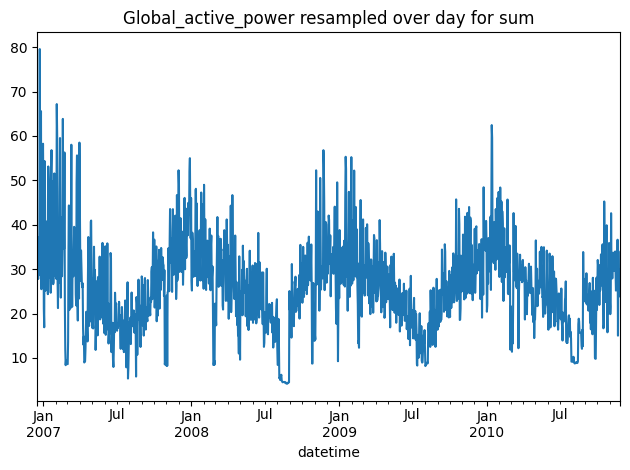

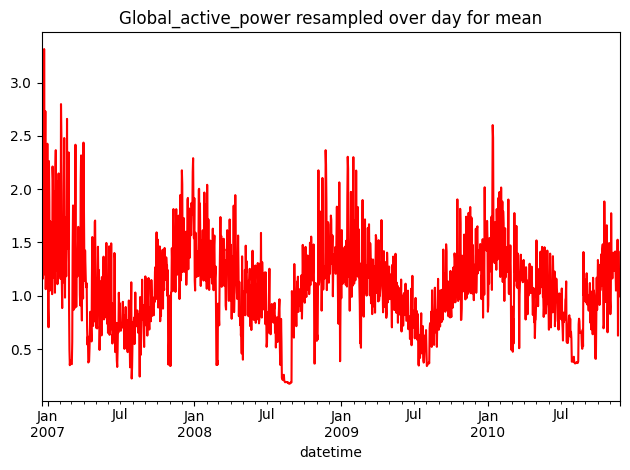

In [38]:
#resample data to daily basis and sum/mean the total values for every date and plot the chart for it
data.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum')
plt.tight_layout()
plt.show()

data.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red')
plt.tight_layout()
plt.show()

In [41]:
import seaborn as sns

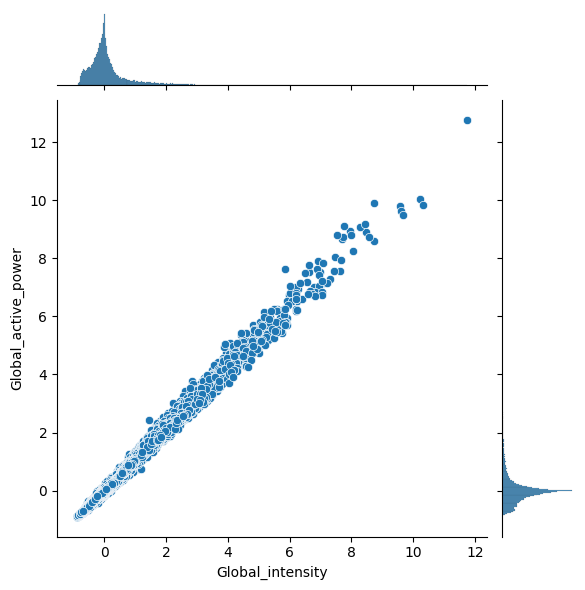

In [42]:
## The correlations between 'Global_intensity', 'Global_active_power'
data_returns = data.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)

plt.show()

This above picture tells us that there is a linear relationship between these two entites and we have a strong positive correlation. There are a few outliers which could be present due to sudden spikes. The distributions are closely concentrated near smaller values telling us that low to moderate usage is miuch more common.

In [43]:
features = ['hour', 'day_of_week', 'month', 'lag_24', 'rolling_mean_3', 'rolling_std_3', 'voltage_intensity_interaction', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
X = data[features]
y = data['Global_active_power']

In [44]:
train_size = 0.6
validation_size = 0.2
test_size = 0.2

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size / (train_size + validation_size), random_state=42, shuffle=False)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# # Standardize features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [47]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

In [48]:
from sklearn.metrics import mean_absolute_percentage_error

In [49]:
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred_val = model.predict(X_val_scaled)
    error = mean_absolute_percentage_error(y_val, y_pred_val)
    results[name] = error
    print(f"{name} MAPE: {error}")

Training Linear Regression...
Linear Regression MAPE: 0.018656500868610124
Training Decision Tree...
Decision Tree MAPE: 0.024399387084747794
Training Random Forest...
Random Forest MAPE: 0.017310116251719656
Training Gradient Boosting...
Gradient Boosting MAPE: 0.01899206551065783
Training SVR...
SVR MAPE: 0.07314642997117372


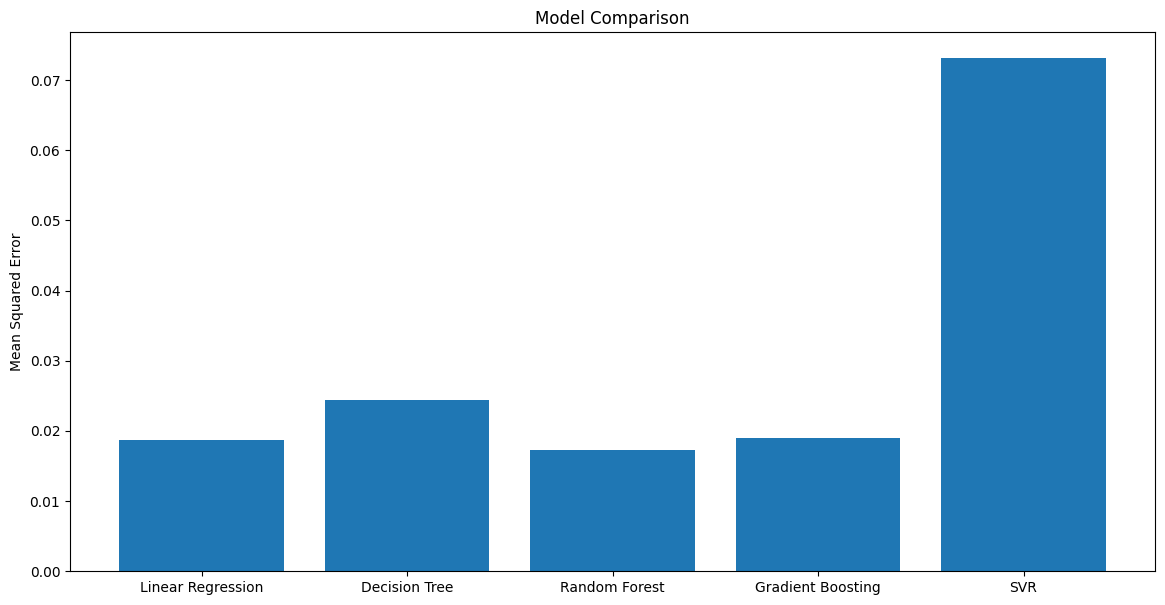

In [50]:
# Plot the errors
plt.figure(figsize=(14, 7))
plt.bar(results.keys(), results.values())
plt.ylabel('Mean Squared Error')
plt.title('Model Comparison')
plt.show()